In [5]:
# plot imports
import matplotlib.pyplot as plt
from lc_tda.plot import rcparams, format_axis_im

# other imports
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm

# format figures
rcparams(1)

# define color cycle
COLOR = ['#515151', '#df5048', '#3370d8', '#5baa71',
         '#a87bd8', '#c49b33', '#5bc8ca', '#76504f',
         '#8e8c2b', '#ea6f2d', '#7099c8', '#80b537']


### 1. Load Endpoint Image


In [6]:
def extract_endpoint(file, type='rh'):
    """
    A function to extract the endpoint frame of a video.
    Args:
        file (str): file directory
        type (str, optional): 'rh' or 'so2'. Defaults to 'rh'.

    Returns:
        img: numpy array, image
        conc: float, relative humidity
    """
    # locate the relative humidity from file name
    if type == 'rh':
        conc = float(file.split('/')[-2].split('+')[-1][:2]) / 100
    elif type == 'so2':
        conc = float(file.split('/')[-2].split('ppm')[0])

    # capture the video
    cap = cv2.VideoCapture(file)

    # the length of the video
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # normally it reads the last frame
    # but sometimes, the last few frames are blank
    # so I use a while loop to locate the last frame
    flag = True
    j = 1
    while flag:
        try:
            cap.set(cv2.CAP_PROP_POS_FRAMES, length - j)
            res, frame = cap.read()
            # convert bgr to rgb
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            flag = False
        except:
            j += 1
    return img, conc


### 2. Locate Boxes in the End Frame


In [3]:
def preprocess(img, d=134):
    """
    A function to crop and normalize images.
    Args:
        img: numpy array, image
        d: int, side length

    Returns:
        img: numpy array, processed image
    """
    dx, dy, _ = img.shape

    hx = int(dx / 2)
    hy = int(dy / 2)
    hd = int(d / 2)

    # select the center
    img = img[hx - hd:hx + hd, hy - hd:hy + hd, :]

    # normalize the images
    img = img / 255.0
    return img


def crop(img):
    """
    A function to crop the boxes from the frame.
    Args:
        img: numpy array, image

    Returns:
        box: list, contains cropped box images
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # define threshold
    thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    box = []
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)

        # only if the box width and height in correct range
        if (w > 135) and (w < 146) and (h > 135) and (h < 146):
            box.append(img[y:y + h, x:x + w])

    return box


def select_best(box):
    """
    A function to select the best 72 images for each relative humidity
    Args:
        box: list, contains cropped box images

    Returns:
        box: list, contains the best 72 cropped box images
    """
    # number of empty pixels
    box_emp = [len(np.where(box[i].mean(axis=-1) <= 60)[0])
               for i in range(len(box))]

    # select the images with less empty pixels (bad images)
    box_ind = np.argsort(box_emp)[:72]
    box = [preprocess(box[i]) for i in box_ind]
    return box


### 3. Different RHs


17


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


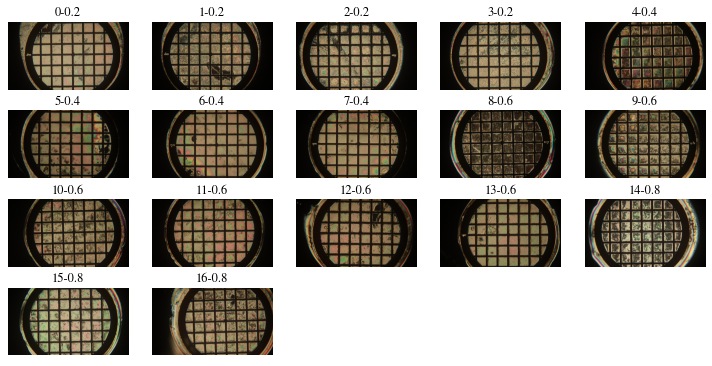

In [7]:
files = glob.glob('/Users/sjiang87/data/video/*/*.MP4')
files.sort()
print(len(files))

# plot all last frames to choose the good ones
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 6))
ax = ax.ravel()
for i in tqdm(range(20)):
    if i < len(files):
        img, conc = extract_endpoint(files[i])
        ax[i].imshow(img)
        ax[i].set_title(f'{i}-{conc:0.1f}', fontsize=12)
    format_axis_im(ax[i])
    ax[i].axis('off')


In [8]:
# good video id for each relative humidity

file_ind = [[0, 1, 3], [5, 6, 7], [11, 12, 13], [14, 15, 16]]

x = []
for i in range(len(file_ind)):
    box = []
    for j in file_ind[i]:
        # extract endpoint frame
        img, conc = extract_endpoint(files[j])

        # append box images for each frame
        box += crop(img)

    # select the best 72 images for each relative humidity
    x += select_best(box)

x = np.array(x)

y = np.array([0.2] * 72 + [0.4] * 72 + [0.6] * 72 + [0.8] * 72)


In [9]:
with open('../data/so2rh/endpoint_rh.pickle', 'wb') as handle:
    pickle.dump(x, handle)
    pickle.dump(y, handle)

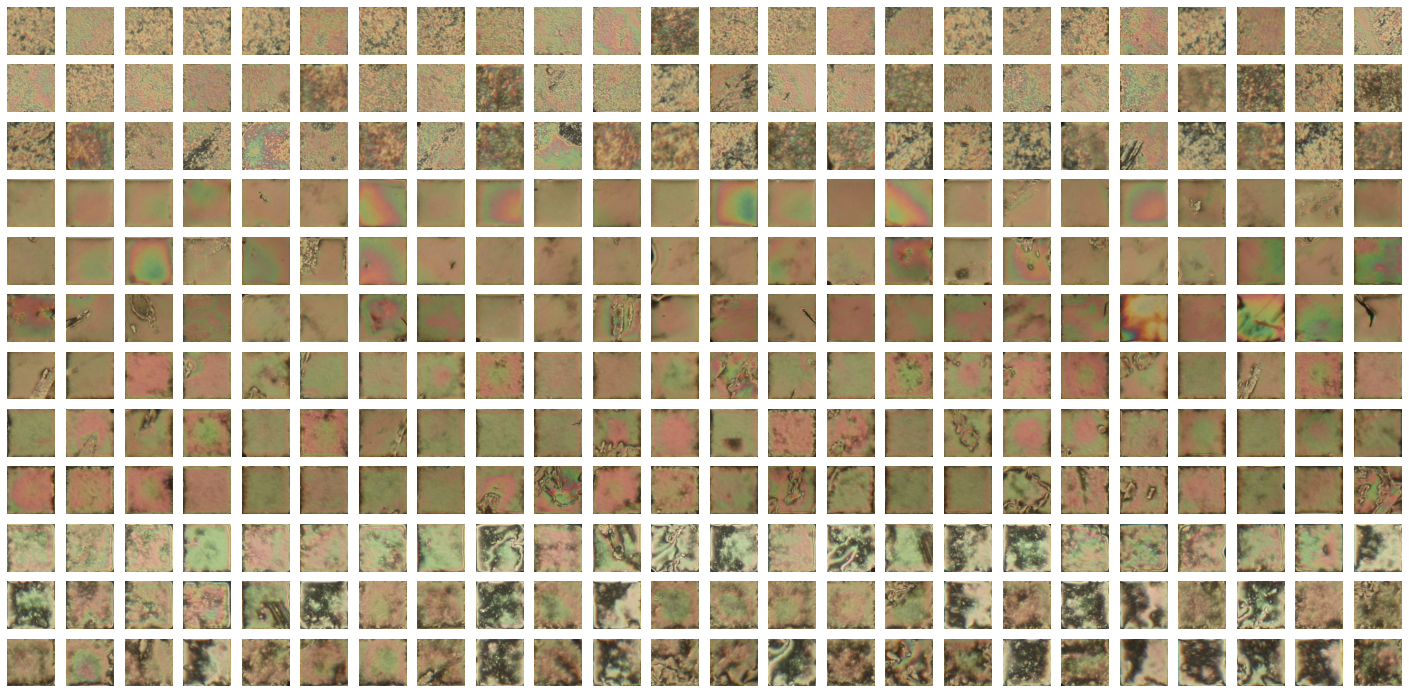

In [11]:
fig, ax = plt.subplots(nrows=12, ncols=24, figsize=(24, 12))
ax = ax.ravel()
for j in range(288):
    ax[j].imshow(x[j])
    ax[j].axis('off')

### 4. Different SO2 Concentrations

In [12]:
files = glob.glob('/Users/sjiang87/data/video/40RH/*/*.MP4') + glob.glob('/Users/sjiang87/data/video/40RH/*/*.mp4') 
files.sort()
print(len(files))

11


In [14]:
file_ind = [[0, 1, 2], [4, 5, 6], [8, 9, 10]]

x = []
for i in range(len(file_ind)):
    box = []
    for j in file_ind[i]:
        # extract endpoint frame
        img, conc = extract_endpoint(files[j], type='so2')

        # append box images for each frame
        box += crop(img)

    # select the best 72 images for each relative humidity
    x += select_best(box)

x = np.array(x)

y = np.array([0.5] * 72 + [1] * 72 + [5] * 72)

In [15]:
with open('../data/so2rh/endpoint_rh.pickle', 'rb') as handle:
    x_ = pickle.load(handle)
    y_ = pickle.load(handle)

x_ = x_[y_ == 0.4]
y_ = np.ones(72) * 2

x = np.concatenate((x, x_), axis=0)
y = np.concatenate([y, y_])

with open('../data/so2rh/endpoint_so2.pickle', 'wb') as handle:
    pickle.dump(x, handle)
    pickle.dump(y, handle)

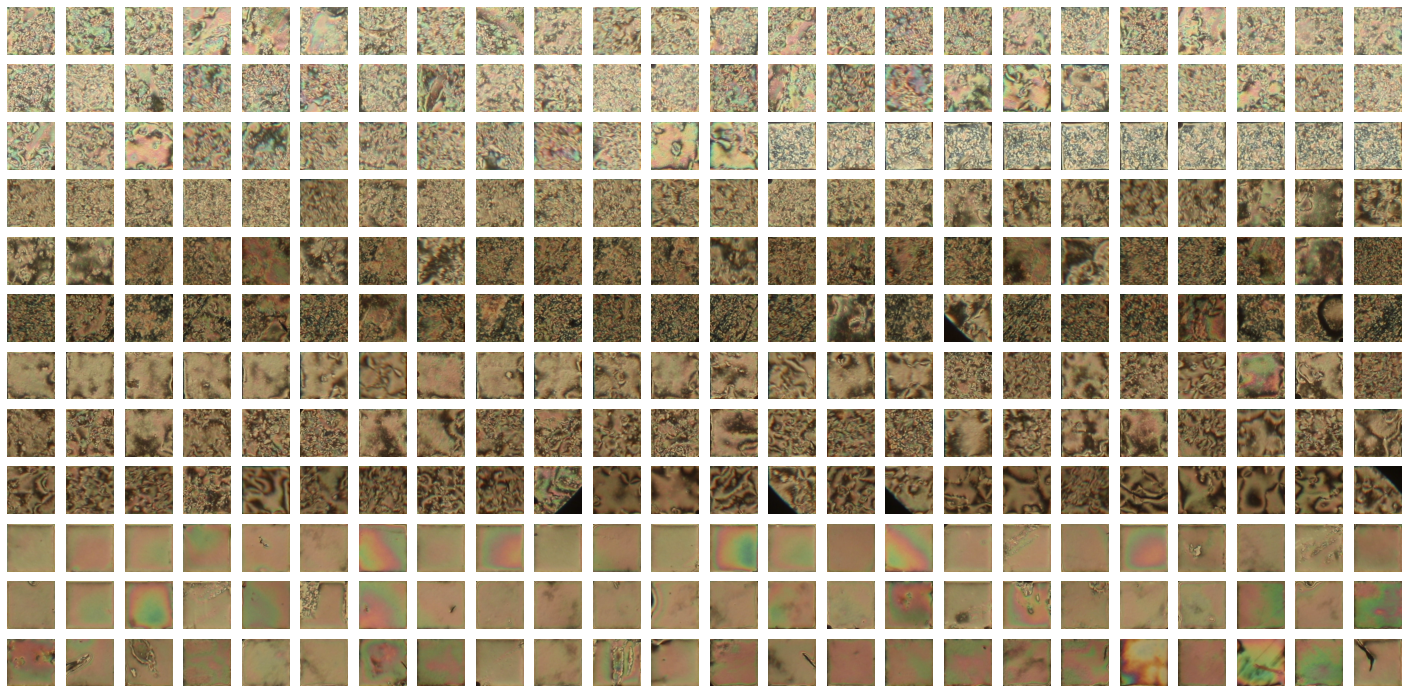

In [16]:
fig, ax = plt.subplots(nrows=12, ncols=24, figsize=(24, 12))
ax = ax.ravel()
for j in range(288):
    ax[j].imshow(x[j])
    ax[j].axis('off')